<a href="https://colab.research.google.com/github/jdiazi/marvin_block_model/blob/main/marvin_bm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
marvin = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Marvin.csv")
marvin[:2]

,X,Y,Z,CU,AU,density,value_process,value_plant
0,15,15,15,0.00,0.00,2.27,-299880.00,-55080.00
1,15,15,45,0.00,0.00,2.27,-299880.00,-55080.00


In [ ]:
# Conditions
AuPrice = 12
AuSelling = .2
AuRec = .6
CuPrice = 20
CuSelling = 7.2
CuRec = .88

In [ ]:
marvin["CUEQ"] = marvin.CU + marvin.AU*(AuPrice-AuSelling)*AuRec/((CuPrice-CuSelling)/CuRec)
marvin["TON"] = (15**3)*marvin.density
marvin["MAXVALUE"] = marvin[["value_process", "value_plant"]].max(axis=1)

In [ ]:
marvin[:2]

,X,Y,Z,CU,AU,density,value_process,value_plant,CUEQ,TON,MAXVALUE
0,15,15,15,0.00,0.00,2.27,-299880.00,-55080.00,0.00,7650.01,-55080.00
1,15,15,45,0.00,0.00,2.27,-299880.00,-55080.00,0.00,7650.01,-55080.00


## **Marvin Block Model with optimazed values**

In [ ]:
maropt = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/marvin2.xlsx")
maropt[:2]

,X,Y,Z,CU,AU,CUEQ,VALUEPROCESS,VALUEWASTE,TON,MAXVVALUE,PF,NESTED1,NESTEDVALUE1,NESTED1WASTE,NESTED2,NESTEDVALUE2,NESTED2WASTE,Tesp,Fase,age1,age2,age3,age4,age5,age6,age7,age8,Tiempo,Total CU
0,15,15,15,0.00,0.00,0.00,-299880.00,-55080.00,61200.09,-55080.00,0,0,-55998.08,1,0,-55080.08,1,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00
1,15,15,45,0.00,0.00,0.00,-299880.00,-55080.00,61200.09,-55080.00,0,0,-57834.09,1,0,-55080.08,1,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00


In [ ]:
def incremental_pbp(df):
  pbp = pd.pivot_table(df, values="TON", index="NESTED2", columns="NESTED2WASTE", aggfunc=np.sum)
  pbp["TotalTon"] = pbp.iloc[:,0] + pbp.iloc[:,1]
  pbp = pbp.rename(columns={0: 'Ore', 1: 'Waste'})
  pbp["TotalProfit"] = pd.pivot_table(df, values="MAXVVALUE", index="NESTED2", aggfunc=np.sum)
  pbp["Profit/ton"] = pbp.TotalProfit/pbp.TotalTon

  # Delete Pitshell 0
  pbp.drop(0, inplace=True)

  # Fill NaN with 0
  pbp.fillna(0, inplace=True)

  # Finding and filling missing pitshells
  missing_pits = [x for x in range(pbp.index.min(),100) if not x in pbp.index]
  for i in missing_pits:
    pbp.loc[i] = 0
  return pbp.sort_index()

In [ ]:
inc_pbp = incremental_pbp(maropt)
inc_pbp[:5]

NESTED2WASTE,Ore,Waste,TotalTon,TotalProfit,Profit/ton
NESTED2,,,,,
57,91013234.12,12925963.63,103939197.75,516609196.92,4.97
58,12029989.86,3538331.05,15568320.91,71437348.81,4.59
59,20397990.51,6263162.64,26661153.15,120645492.96,4.53
60,12649730.04,6104407.56,18754137.60,72732713.44,3.88
61,10741746.42,4778848.29,15520594.71,59824864.01,3.85


In [ ]:
def cumulative_pbp():
  del inc_pbp["Profit/ton"]
  pbpCum = inc_pbp.cumsum()
  pbpCum["Profit/ton"] = pbpCum.TotalProfit/pbpCum.TotalTon
  return pbpCum

In [ ]:
cum_pbp = cumulative_pbp()
cum_pbp[:5]

NESTED2WASTE,Ore,Waste,TotalTon,TotalProfit,Profit/ton
NESTED2,,,,,
57,91013234.12,12925963.63,103939197.75,516609196.92,4.97
58,103043223.98,16464294.68,119507518.66,588046545.73,4.92
59,123441214.49,22727457.32,146168671.81,708692038.69,4.85
60,136090944.53,28831864.88,164922809.41,781424752.13,4.74
61,146832690.95,33610713.17,180443404.12,841249616.13,4.66


## **Pit by Pit and Profit/Ton graphs**

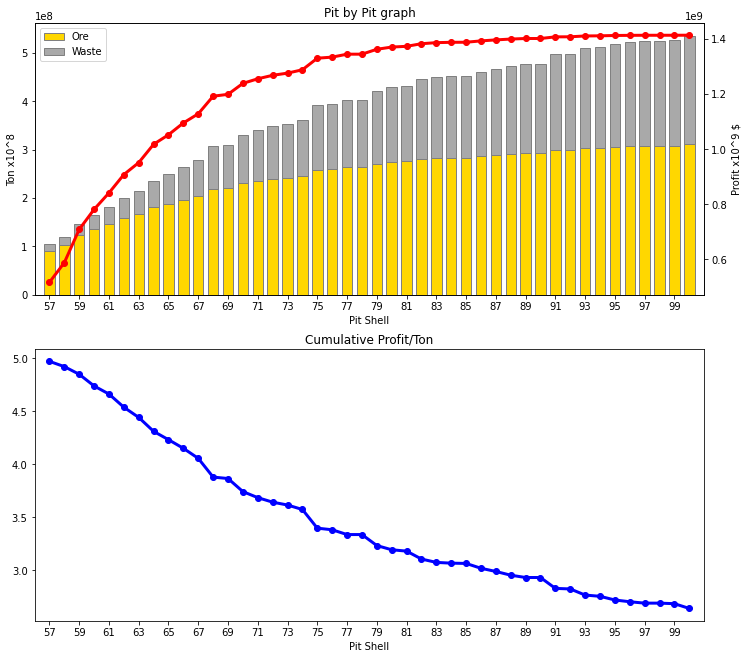

In [ ]:
labels = cum_pbp.index
ore = cum_pbp.Ore.values
waste = cum_pbp.Waste.values
profit = cum_pbp.TotalProfit.values
width = .7

fig, axs = plt.subplots(2, figsize=(12,11))
# Setting the values for all axes.
plt.setp(axs, xlim=(56, 101), xticks=np.arange(57,101,2), xlabel="Pit Shell")

# Pit by Pit graph
axs[0].bar(labels, ore, width, label='Ore', color='gold', edgecolor="gray")
axs[0].bar(labels, waste, width, label='Waste', color='darkgray', bottom=ore, edgecolor="gray")
ax2 = axs[0].twinx()
ax2.plot(labels, profit, 'ro-',linewidth=3)

axs[0].set_ylabel('Ton x10^8')
ax2.set_ylabel('Profit x10^9 $')
axs[0].set_title('Pit by Pit graph')
axs[0].legend()

# Profit/ton graph
profit_ton = cum_pbp["Profit/ton"].values
axs[1].plot(labels, profit_ton, 'bo-',linewidth=3)
axs[1].set_title('Cumulative Profit/Ton')

plt.show()

## **Production Plan**

In [ ]:
def production_plan(df):
  col1 = ['TON', 'MAXVVALUE', 'CUEQ', 'NESTED2WASTE']
  col2 = ['TON', 'MAXVVALUE', 'CUEQ', 'NESTED2WASTE'] + maropt.loc[:,"age1":"age8"].columns.to_list()
  df = df[col2]
  df2 = df.melt(id_vars=col1, var_name='Period', value_name='Proportion')

  df2['Tonnage'] = df2['TON']*df2['Proportion']
  ore = df2[df2['NESTED2WASTE']==0].groupby('Period')['Tonnage'].sum().rename('Ore')
  waste = df2[df2['NESTED2WASTE']==1].groupby('Period')['Tonnage'].sum().rename('Waste')
  total = (ore + waste).rename('Total')

  df2['Value'] = df2['MAXVVALUE']*df2['Proportion']
  value = df2.groupby('Period')['Value'].sum()

  df2['Cu'] = df2['TON']*df2['Proportion']*df2['CUEQ']
  cu = (df2[df2['NESTED2WASTE']==0].groupby('Period')['Cu'].sum()/ore).rename('Cu')

  plan_df = pd.concat([ore, waste, total, cu, value], axis=1)
  plan_df['Year'] = np.arange(1,9)
  plan_df['NPV'] = plan_df['Value']/(1.1**plan_df['Year'])
  plan_df.set_index('Year', inplace=True)
  return plan_df

In [ ]:
prod = production_plan(maropt)
prod

,Ore,Waste,Total,Cu,Value,NPV
Year,,,,,,
1,19999999.52,16822157.72,36822157.24,0.57,15623705.37,14203368.52
2,19999992.69,0.00,19999992.69,0.71,61505158.77,50830709.73
3,19999998.51,4391690.67,24391689.18,0.85,89907829.80,67549083.24
4,20000000.95,1441248.93,21441249.88,0.94,113140764.09,77276664.22
5,20000001.17,72360.00,20072361.17,1.17,165276500.20,102623703.17
6,19999996.15,7252930.55,27252926.70,1.42,215440323.82,121610446.28
7,19999997.95,40000004.67,60000002.62,0.74,33539665.69,17211151.73
8,20000003.47,3953999.88,23954003.35,0.83,85906061.21,40075811.56


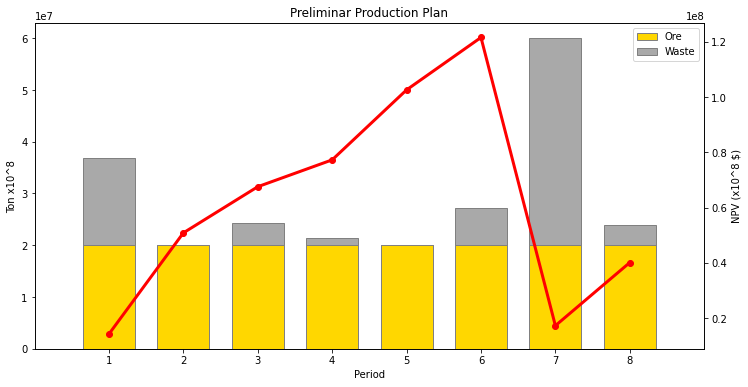

In [ ]:
labels = prod.index
ore = prod.Ore.values
waste = prod.Waste.values
value = prod.Value.values
npv = prod.NPV.values
width = .7

fig, ax = plt.subplots(figsize=(12,6))

# Setting the values for all axes.
plt.setp(ax, xlim=(0,9), xticks=np.arange(1,9), xlabel="Period")

# Pit by Pit graph
ax.bar(labels, ore, width, label='Ore', color='gold', edgecolor="gray")
ax.bar(labels, waste, width, label='Waste', color='darkgray', bottom=ore, edgecolor="gray")
ax2 = ax.twinx()
ax2.plot(labels, npv, 'ro-',linewidth=3)

ax.set_ylabel('Ton x10^8')
ax2.set_ylabel('NPV (x10^8 $)')
ax.set_title('Preliminar Production Plan')
ax.legend()

plt.show()